In [13]:
# 필요한 라이브러리들을 임포트합니다.
from glob import glob
import os

In [14]:
# 필요한 라이브러리를 설치합니다.
! pip install segmentation_models_pytorch

### 데이터 경로를 설정합니다.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# 데이터 경로를 설정해줍니다.
data_directory = '/content/drive/MyDrive/SNU/23Fall/MAICON/Computer Vision 모의 과제/copy_dataset'

# 학습용 데이터 경로와 마스크 경로를 설정해줍니다.
train_image_directory = os.path.join(data_directory, 'train', 'images') # 학습용 이미지 경로
train_mask_directory = os.path.join(data_directory, 'train', 'masks') # 학습용 마스크 경로

# 테스트용 데이터 경로와 마스크 경로를 설정해줍니다.
test_image_directory = os.path.join(data_directory, 'test', 'images') # 테스트용 이미지 경로

In [16]:
# 각 경로에 존재하는 파일들의 경로를 리스트로 저장합니다.
train_image_paths = sorted(glob(os.path.join(train_image_directory, '*.jpg')))
train_mask_paths = sorted(glob(os.path.join(train_mask_directory, '*.png')))

test_image_paths = sorted(glob(os.path.join(test_image_directory, '*.jpg')))

# 각 이미지와 마스크의 수량을 체크하는 코드입니다.
print(f'학습용 이미지 개수 : {len(train_image_paths)}, 마스크 개수 : {len(train_mask_paths)}')
print(f'평가용 이미지 개수 : {len(test_image_paths)}')

학습용 이미지 개수 : 5986, 마스크 개수 : 5986
평가용 이미지 개수 : 3992


In [8]:
# 이미지와 마스크의 경로 예시를 보고 혹시 파일 리스트가 순서대로 정렬되어 있지 않는지 확인해봅니다.
print(f'이미지 경로 예시 : {train_image_paths[:5]}')
print(f'마스크 경로 예시 : {train_mask_paths[:5]}')

이미지 경로 예시 : ['/content/drive/MyDrive/SNU/23Fall/MAICON/Computer Vision 모의 과제/copy_dataset/train/images/train_00000.jpg', '/content/drive/MyDrive/SNU/23Fall/MAICON/Computer Vision 모의 과제/copy_dataset/train/images/train_00001.jpg', '/content/drive/MyDrive/SNU/23Fall/MAICON/Computer Vision 모의 과제/copy_dataset/train/images/train_00002.jpg', '/content/drive/MyDrive/SNU/23Fall/MAICON/Computer Vision 모의 과제/copy_dataset/train/images/train_00003.jpg', '/content/drive/MyDrive/SNU/23Fall/MAICON/Computer Vision 모의 과제/copy_dataset/train/images/train_00004.jpg']
마스크 경로 예시 : ['/content/drive/MyDrive/SNU/23Fall/MAICON/Computer Vision 모의 과제/copy_dataset/train/masks/train_00000.png', '/content/drive/MyDrive/SNU/23Fall/MAICON/Computer Vision 모의 과제/copy_dataset/train/masks/train_00001.png', '/content/drive/MyDrive/SNU/23Fall/MAICON/Computer Vision 모의 과제/copy_dataset/train/masks/train_00002.png', '/content/drive/MyDrive/SNU/23Fall/MAICON/Computer Vision 모의 과제/copy_dataset/

### 데이터셋 분할

In [17]:
# 학습과 검증을 위해서 학습 데이터를 train과 val 데이터셋으로 나눠줍니다.
# 비중은 8:2로 해보겠습니다.
from sklearn.model_selection import train_test_split

train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(train_image_paths,
                                                                                        train_mask_paths,
                                                                                        test_size=0.2,
                                                                                        random_state=2021)

# 데이터의 수량을 확인해봅니다.
print(f'학습 데이터 개수 : {len(train_image_paths)}, 검증 데이터 개수 : {len(val_image_paths)}, 평가용 데이터 개수 : {len(test_image_paths)}')


학습 데이터 개수 : 4788, 검증 데이터 개수 : 1198, 평가용 데이터 개수 : 3992


### Pytorch Dataset 클래스 정의
Pytorch Dataset 클래스는 AI 모델에 데이터를 입력하기 전에 데이터를 가공 및 표준화하는 역할을 합니다.

In [10]:
# 필요한 라이브러리들을 임포트합니다.
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from torchvision import transforms

In [11]:
class SegDataset(Dataset):
    def __init__(self, image_paths, mask_paths=None, resize=(256, 256), mode='train'):
        '''
        image_paths: 이미지 경로들의 리스트
        mask_paths: 마스크 경로들의 리스트
        size: 이미지와 마스크를 리사이즈를 몇으로 할 지 결정하는 변수
        mode: train인지 test인지를 결정하는 변수
        '''
        self.image_paths = image_paths # 이미지 경로들의 리스트를 저장합니다.
        self.mask_paths = mask_paths # 마스크 경로들의 리스트를 저장합니다.
        self.resize = resize # 리사이즈 변수를 저장합니다.
        self.mode = mode # 모드 변수를 저장합니다.
        self.transform = transforms.Compose([
                transforms.ToTensor(), # 텐서 변환
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화
            ]) # 이미지를 텐서로 변환하고 정규화하는 코드입니다.

    def __len__(self):
        return len(self.image_paths) # 데이터셋의 길이를 반환합니다.

    def __getitem__(self, idx):
        image_path = self.image_paths[idx] # idx 번째 이미지 경로를 불러옵니다. ex) 전체 이미지 중 첫 번째 이미지
        filename = os.path.basename(image_path) # 이미지 경로에서 이미지 파일의 이름을 불러옵니다. ex) train_0001.png

        # image를 불러옵니다.
        image = Image.open(image_path) # 이미지 경로를 참조해 이미지를 불러옵니다. BGR 형태의 이미지입니다.
        image = image.convert('RGB') # RGB 형태로 변환합니다.
        image_size = torch.tensor(image.size) # 이미지의 사이즈를 저장합니다.

        # image를 resize합니다.
        image = image.resize(self.resize)

        # image를 torch tensor로 변환합니다.
        image = self.transform(image).float() # 딥러닝 모델의 입력은 float형이어야 합니다.

        if self.mode == 'train' or self.mode == 'val':
            mask_path = self.mask_paths[idx] # idx 번째 마스크 경로를 불러옵니다.

            # mask를 로드합니다.
            mask = Image.open(mask_path) # 마스크 경로를 참조해 마스크(정답)를 불러옵니다. Gray 이미지이며, 0부터 59 사이의 값을 가집니다.

            # mask를 resize합니다.
            # 마스크 이미지는 resize 할때 iterpolation 방식에 각별히 주의해야 합니다.
            # linear interpolation 등을 사용하면 유효하지 않은 mask 값이 될 수 있습니다.
            # 따라서 주변에 있는 픽셀 값으로 interpolation 해야합니다.
            mask = mask.resize(self.resize, resample=Image.NEAREST) # 마스크를 리사이징합니다.

            # mask를 torch tensor로 변환합니다.
            mask = torch.from_numpy(np.array(mask)).long() # 정답은 정수형이어야 하므로 long형으로 변환합니다.

        else:
            mask = np.zeros(self.resize) # 테스트 데이터셋의 경우 마스크가 없으므로 0으로 채워진 마스크를 만듭니다.
        # 이미지, 마스크, 파일이름, 이미지 원본 사이즈 순으로 반환합니다.
        return image, mask, filename, image_size

In [12]:
# 학습 및 검증 데이터셋을 생성합니다.
train_dataset = SegDataset(train_image_paths, train_mask_paths, mode='train') # 학습 (train) 데이터 인스턴스 생성
val_dataset = SegDataset(val_image_paths, val_mask_paths, mode='val') # 검증 (valid) 데이터 인스턴스 생성
test_dataset = SegDataset(test_image_paths, mode='test') # 평가 (test) 데이터 인스턴스 생성
# 데이터의 수량을 확인해봅니다.
print(f'학습 데이터셋의 수 : {len(train_dataset)}, 검증 데이터셋의 수 : {len(val_dataset)}, 평가 데이터셋의 수 : {len(test_dataset)}')

학습 데이터셋의 수 : 4788, 검증 데이터셋의 수 : 1198, 평가 데이터셋의 수 : 3992


### DataLoader를 정의합니다.
데이터 로더는 데이터를 배치 (batch) 형태로 구성하는 역할을 합니다.
배치 단위로 데이터를 구성하면 더 빨리 학습할 수 있습니다.

In [30]:
# pytorch dataloader를 구현합니다.
from torch.utils.data import DataLoader


# batch_size : 한번에 몇 개의 데이터를 가져올지 결정하는 변수
# shuffle : 데이터를 섞을지 여부를 결정하는 변수
# num_workers : 데이터를 가져올 프로세스의 개수를 결정하는 변수

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2) # 학습 데이터 로더
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2) # 검증 데이터 로더
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2) # 평가 데이터 로더


In [19]:
# 학습 데이터 로더로부터 첫 번째 배치를 가져옵니다.
image, mask, filename, image_size = next(iter(train_loader))

print(image.shape) # image의 형태를 확인합니다.
print(mask.shape) # mask의 형태를 확인합니다.
print(filename) # 파일 이름을 확인합니다.
print(image_size) # 이미지의 원본 사이즈를 확인합니다.

torch.Size([16, 3, 256, 256])
torch.Size([16, 256, 256])
('train_03068.jpg', 'train_00130.jpg', 'train_02108.jpg', 'train_02581.jpg', 'train_05373.jpg', 'train_05009.jpg', 'train_01165.jpg', 'train_01325.jpg', 'train_03024.jpg', 'train_05946.jpg', 'train_03904.jpg', 'train_03482.jpg', 'train_00409.jpg', 'train_05593.jpg', 'train_02003.jpg', 'train_01956.jpg')
tensor([[448, 448],
        [448, 448],
        [448, 448],
        [448, 448],
        [448, 448],
        [448, 448],
        [448, 448],
        [448, 448],
        [448, 448],
        [448, 448],
        [448, 448],
        [448, 448],
        [448, 448],
        [448, 448],
        [448, 448],
        [448, 448]])


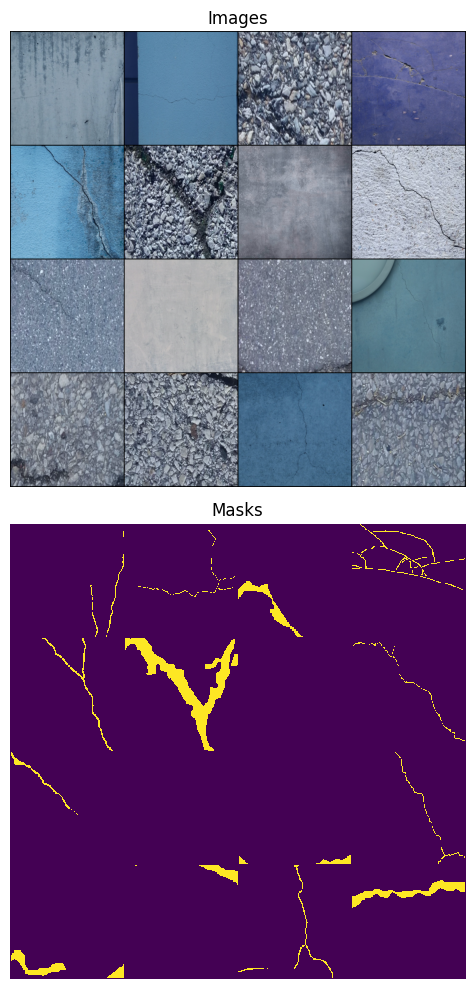

In [20]:
# 이미지와 마스크를 시각화해서 데이터셋 클래스가 제대로 만들어졌는지 확인해봅니다.
import matplotlib.pyplot as plt

# 이미지와 마스크를 시각화하는 함수입니다.
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# 함수를 정의합니다.
def visualize_batch(images, masks):
    # 이미지와 마스크를 그리드로 만듭니다.
    image_grid = make_grid(images, nrow=4, normalize=True) # 이미지 그리드 생성
    mask_grid = make_grid(masks.unsqueeze(1).float(), nrow=4, normalize=False, scale_each=False) # 마스크 그리드 생성

    # 이미지와 마스크를 시각화합니다.
    plt.figure(figsize=(15, 10))
    plt.subplot(211)
    plt.imshow(image_grid.permute(1, 2, 0)) # 이미지를 시각화합니다.
    plt.title('Images')
    plt.axis('off')

    plt.subplot(212)
    plt.imshow(mask_grid[0], interpolation='nearest') # 마스크를 시각화합니다.
    plt.title('Masks')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# DataLoader에서 데이터를 가져옵니다.
for images, masks, _, _ in train_loader:
    # 시각화 함수를 호출하여 이미지와 마스크를 시각화합니다.
    visualize_batch(images, masks)
    break  # 하나의 배치만 시각화하고 종료합니다.

### 모델을 정의합니다.

In [21]:
# 모델을 구현합니다.
# 모델은 세그멘테이션에 많이 사용하는 구조인 U-Net을 사용하겠습니다.

# 필요한 라이브러리를 임포트합니다.
import torch.nn as nn
import segmentation_models_pytorch as smp

# 어떤 장치에서 학습할지 결정합니다. cuda는 gpu를 사용한다는 것을 의미합니다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델을 정의합니다.
model = smp.Unet(classes=2, # 의류 종류 수에 맞게 클래스를 결정합니다.
                 encoder_name = 'timm-efficientnet-b0', # encoder 모델 구조를 결정합니다.
                 encoder_weights = 'imagenet') # encoder 모델에 어떤 사전학습 모델을 적용할지 지정합니다.

# 모델을 장치에 할당합니다.
model = model.to(device)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 363MB/s]


### 학습을 위한 optimizer, loss 함수 등을 정의합니다.

In [23]:
# 필요한 라이브러리를 임포트합니다.
import torch.optim as optim

# optimizers는 SGD를 사용하겠습니다.
optimizer = optim.SGD(model.parameters(), lr=0.01)

# loss 함수는 CrossEntropyLoss를 사용하겠습니다.
loss_function = nn.CrossEntropyLoss()

### 모델 학습과 검증을 수행합니다.

In [25]:
import shutil

# 학습된 모델을 저장할 경로를 설정합니다.
save_directory = '/content/drive/MyDrive/SNU/23Fall/MAICON/Computer Vision 모의 과제/results/model'

# 이미 경로가 있으면 삭제합니다.
if os.path.isdir(save_directory):
  shutil.rmtree(save_directory)

# 경로를 생성합니다.
os.makedirs(save_directory, exist_ok=True)

In [24]:
# 필요한 라이브러리를 임포트합니다.
from tqdm import tqdm, trange
import torch

num_epochs = 1 # 학습할 에폭의 수를 결정합니다.
best_acc = 0

for epoch in range(num_epochs):

    # 학습을 수행합니다.
    model.train() # 모델을 학습 모드로 설정합니다.

    # 학습 데이터에 대한 정답율을 기록할 리스트를 선언합니다.
    train_accs = []

    # 학습 데이터셋으로부터 데이터를 가져옵니다.
    for image, mask, filename, image_size in tqdm(train_loader, position=0, leave=True, desc=f'epoch: {epoch} | train'):

        # 가져온 데이터를 장치에 할당합니다.
        image = image.to(device) # 이미지의 차원은 [배치사이즈, 채널 수, 이미지 높이, 이미지 넓이]입니다.
        mask = mask.to(device) # 마스크의 차원은 [배치사이즈, 이미지 높이, 이미지 넓이]입니다.

        # 모델의 출력값을 계산합니다.
        # 예측 결과인 pred_mask는 [배치사이즈, 클래스 수, 이미지 높이, 이미지 넓이]차원의 행렬 형태를 가집니다.
        pred_mask = model(image)

        # loss를 계산합니다.
        loss = loss_function(pred_mask, mask)

        # loss를 통해 모델을 학습합니다.
        optimizer.zero_grad() # gradient를 초기화합니다.
        loss.backward() # gradient를 계산합니다.
        optimizer.step() # gradient를 통해 파라미터를 업데이트합니다.

        # argmax 연산을 통해 확률이 가장 높은 클래스를 예측값으로 선택합니다.
        # [배치사이즈, 클래스 수, 이미지 높이, 이미지 넓이] -> [배치사이즈, 이미지 높이, 이미지 넓이]로 변환됩니다.
        pred_mask = torch.argmax(pred_mask, dim=1)

        # 해당 배치에 대한 성능 평가를 진행합니다.
        batch_acc =  (pred_mask == mask).float().mean().cpu().item()
        train_accs.append(batch_acc)

    # 검증을 수행합니다.
    model.eval() # 모델을 검증 모드로 설정합니다.

    # 검증 데이터에 대한 정답율을 기록할 리스트를 선언합니다.
    val_accs = []

    # 검증 데이터셋으로부터 데이터를 가져옵니다.
    for image, mask, filename, image_size in tqdm(val_loader, position=0, leave=True, desc=f'epoch: {epoch} | val'):

            # 가져온 데이터를 장치에 할당합니다.
            image = image.to(device) # 이미지의 차원은 [배치사이즈, 채널 수, 이미지 높이, 이미지 넓이]입니다.
            mask = mask.to(device) # 마스크의 차원은 [배치사이즈, 이미지 높이, 이미지 넓이]입니다.

            # 모델의 출력값을 계산합니다.
            # 예측 결과인 pred_mask는 [배치사이즈, 클래스 수, 이미지 높이, 이미지 넓이]차원의 행렬 형태를 가집니다.
            pred_mask = model(image)

            # argmax 연산을 통해 확률이 가장 높은 클래스를 예측값으로 선택합니다.
            # [배치사이즈, 클래스 수, 이미지 높이, 이미지 넓이] -> [배치사이즈, 이미지 높이, 이미지 넓이]로 변환됩니다.
            pred_mask = torch.argmax(pred_mask, dim=1)

            # 해당 배치에 대한 성능 평가를 진행합니다.
            batch_acc =  (pred_mask == mask).float().mean().cpu().item()
            val_accs.append(batch_acc)

    train_acc = sum(train_accs) / len(train_accs)
    val_acc = sum(val_accs) / len(val_accs)

    print(f'에폭 : {epoch}, 학습 정확도 : {train_acc}, 검증 정확도 : {val_acc}')

    # validation accuracy가 최고를 갱신하면 모델을 저장합니다.
    if val_acc > best_acc: # 이번 에폭의 기존의 최고 accuracy보다 높으면
      best_acc = val_acc # 최고 accuracy를 갱신하고
      torch.save(model.state_dict(), f'{save_directory}/best_model.pt') # 모델을 저장합니다.
      print(f'Best performance at epoch {epoch} : {best_acc}')


epoch: 0 | train: 100%|██████████| 300/300 [24:20<00:00,  4.87s/it]
epoch: 0 | val: 100%|██████████| 75/75 [06:11<00:00,  4.95s/it]

에폭 : 0, 학습 정확도 : 0.9628526782989502, 검증 정확도 : 0.9699057666460673


NameError: ignored

# 추론을 수행합니다.

In [27]:
# 학습이 완료된 모델을 로드합니다.
model = smp.Unet(classes=2, # 의류 종류 수에 맞게 클래스를 결정합니다.
                 encoder_name = 'timm-efficientnet-b0', # encoder 모델 구조를 결정합니다.
                 encoder_weights = 'imagenet') # encoder 모델에 어떤 사전학습 모델을 적용할지 지정합니다.

model = model.to(device)
model.load_state_dict(torch.load(f'{save_directory}/best_model.pt'))

<All keys matched successfully>

In [28]:
# 예측 결과를 저장할 경로를 생성합니다.
pred_directory = '/content/drive/MyDrive/SNU/23Fall/MAICON/Computer Vision 모의 과제/results/pred'

# 이미 경로가 있으면 삭제합니다.
if os.path.isdir(pred_directory):
  shutil.rmtree(pred_directory)

# 경로를 생성합니다.
os.makedirs(pred_directory, exist_ok=True)

In [ ]:
for image, _, filename, image_size in tqdm(test_loader, position=0, leave=True, desc=f'Prediction'):
    # 가져온 데이터를 장치에 할당합니다.
    image = image.to(device)

    # 모델의 출력값을 계산합니다.
    pred_mask = model(image)

    # argmax 연산을 통해 확률이 가장 높은 클래스를 예측값으로 선택합니다.
    pred_mask = torch.argmax(pred_mask, dim=1)

    for i, a_pred_mask in enumerate(pred_mask):
        # pred_mask를 PIL image로 변환합니다.
        pred_mask_image = Image.fromarray(np.uint8(a_pred_mask.cpu().numpy()))

        # 원본 이미지의 크기로 resize합니다.
        pred_mask_image = pred_mask_image.resize(image_size[i])

        filename_ = filename[i].replace('.jpg', '.png')
        # 이미지를 저장합니다.
        pred_mask_image.save(f'{pred_directory}/{filename_}')

Prediction:  99%|█████████▉| 124/125 [20:12<00:09,  9.38s/it]

### 예측 결과물을 압축해서 제출합니다.

In [ ]:
import zipfile

pred_files = glob(f'{pred_directory}/*.png')

# 압축을 수행합니다.
with zipfile.ZipFile('/content/drive/MyDrive/SNU/23Fall/MAICON/Computer Vision 모의 과제/results/sample_submission.zip', 'w') as zip:
    for pred_file in pred_files:
        zip.write(pred_file, os.path.basename(pred_file))